# Aeolian transport data
1) Get data from opendap
2) Output GeoJson with locations
3) Output json per location with timeseries of particle count

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import netCDF4 as nc
import geojson
import json
import urllib
import re
import datetime

## 1) Get dataset from opendap

In [2]:
url_cat = r'http://opendap.tudelft.nl/thredds/catalog/data2/zandmotor/aeolian/megapex/catalog.html'
url_cat_source = str(urllib.request.urlopen(url_cat).read())

# extract filenames attempt 1
filenames = []
url_cat_source_marker = "<a href=\'catalog.html?dataset=[0-9,a-z,A-Z,_,/,.]*.nc\'><tt>"
for line in re.findall(url_cat_source_marker, url_cat_source):
    filenames.append(line[:-6].split(url_cat)[1])
    
# extract filenames attempt 2
filenames = []
for i in range(len(url_cat_source.split('<tt>'))):
    if ('.nc' in url_cat_source.split('<tt>')[i]) & ('deployment' in url_cat_source.split('<tt>')[i]):
        filenames.append(url_cat_source.split('<tt>')[i].split('<a')[-1].split('/')[-1].replace("'>",''))

# filter on merged Netcdf
filenames2 = []
for i in range(len(filenames)):
    if ('dn' in filenames[i]) & ('_merged' not in filenames[i]):
        filenames2.append(filenames[i])
        
print(filenames2)

['deployment_20141021224500_20141023000000_045_46318725_dn11.nc', 'deployment_20141021134000_20141021224500_045_46318725_dn10.nc', 'deployment_20141020051500_20141021134000_090_46318725_dn9.nc', 'deployment_20141013130000_20141020051500_135_46318725_dn8.nc', 'deployment_20141006103000_20141013130000_135_8157_dn6.nc', 'deployment_20141006103000_20141013130000_135_46382_dn7.nc', 'deployment_20141006103000_20141013130000_135_46382157_dn67.nc', 'deployment_20140923100000_20141006103000_090_43825761_dn5.nc', 'deployment_20140921160000_20140923100000_000_374_dn4.nc', 'deployment_20140920180000_20140921160000_098_3748_dn2.nc', 'deployment_20140920180000_20140921160000_000_6125_dn3.nc', 'deployment_20140917000000_20140920180000_098_23748561_dn1.nc']


## 2) Store all locations in GeoJson

<IPython.core.display.Javascript object>


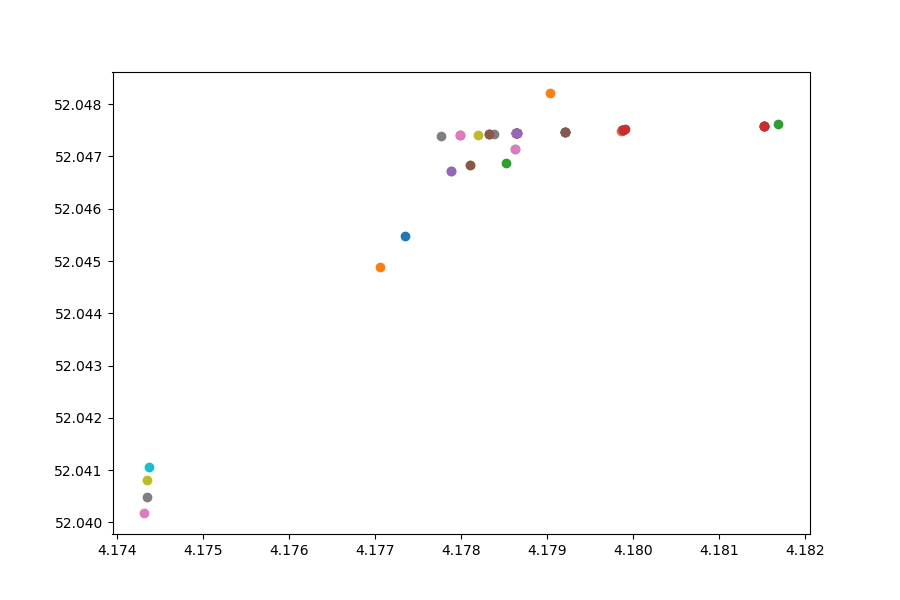

dn11
dn10
dn9
dn8
dn6
dn7
dn67
dn5
dn4
dn2
dn3
dn1


In [7]:
# put to geojson
features = []
plt.figure(figsize=(9,6))

# loop over deployments
for k in range(len(filenames2)):
    url = r'http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/aeolian/megapex/' + filenames2[k]
    dataset = nc.Dataset(url)
    dataset.set_auto_mask(False)
    
    # get general deployment information
    deploymentName = filenames2[k].split('_')[-1].replace('.nc','')
    print(deploymentName)
    
    tstart = datetime.datetime.strptime(filenames2[k].split('_')[1],'%Y%m%d%H%M%S')
    tend = datetime.datetime.strptime(filenames2[k].split('_')[2],'%Y%m%d%H%M%S')

    # put locations to json
    for i in range(len(dataset['lat'])):
        p = geojson.Point((float(dataset['lon'][i]),float(dataset['lat'][i])))
        plt.plot(float(dataset['lon'][i]),float(dataset['lat'][i]),marker='o')
        feature = geojson.Feature(geometry=p,properties={'deploymentName': deploymentName,
                                                         'tStart':int(tstart.timestamp()),
                                                         'tEnd':int(tend.timestamp()),
                                                         'location_ID': '%s_%i' %('location_ID', i)})
        features.append(feature)

featureCollection = geojson.FeatureCollection(features)

f = open(r'../static/aeolian_data.geojson','w')
f.write(json.dumps(featureCollection))
f.close()

## 3) Store timeseries in json

In [ ]:
# loop over deployments, output single json per deployment
for i in range(len(filenames2)):
    deployments = {}

    url = r'http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/aeolian/megapex/' + filenames2[i]
    dataset = nc.Dataset(url)
    dataset.set_auto_mask(False)
    
    # get general deployment information
    deploymentName = filenames2[i].split('_')[-1].replace('.nc','')
    print(deploymentName)
    
    tstart = datetime.datetime.strptime(filenames2[i].split('_')[1],'%Y%m%d%H%M%S')
    tend = datetime.datetime.strptime(filenames2[i].split('_')[2],'%Y%m%d%H%M%S')
    
    time = dataset['time'][:]
    
    # loop over locations
    locations = {}
    locations['time'] = time.tolist()
    # loop over locations within deployment
    for j in range(np.shape(dataset['particle_count_1'])[1]):        
        # loop over height
        heights = {}
        for k in range(10):
            name = 'particle_count_' + str(k)
            if  name in dataset.variables:
                particle_count = dataset['particle_count_' + str(k)][:,j]
                particle_count[particle_count < 0] = 0
                particle_count = particle_count.tolist()
                particle_height = dataset['particle_count_' + str(k)].height

                heightproperties = {}
                heightproperties['height'] = particle_height
                heightproperties['particle_counts'] = particle_count
                
                heights[name] = heightproperties
                
        locations['%s_%i' %('location_ID', j)] = heights
    deployments[deploymentName] = locations

    # store
    f = open('%s_%s%s' %(r'../static/aeolian_data', deploymentName, '.json'),'w')
    f.write(json.dumps(deployments))
    f.close()

In [ ]:
deployments

## Example plot

In [ ]:
# define location
deploymentName = 'dn1'
locationID ='loc_0'

# get timeseries of particle count at those locations
particle_count_1 = np.sum(dataset['particle_count_1'][:],1)
particle_count_1[particle_count_1 < 0] = 0

particle_count_2 = np.sum(dataset['particle_count_2'][:],1)
particle_count_2[particle_count_2 < 0] = 0

particle_count_3 = np.sum(dataset['particle_count_3'][:],1)
particle_count_3[particle_count_3 < 0] = 0

particle_count_4 = np.sum(dataset['particle_count_4'][:],1)
particle_count_4[particle_count_4 < 0] = 0

heightvalues = [dataset['particle_count_1'].height, dataset['particle_count_2'].height, dataset['particle_count_3'].height, dataset['particle_count_4'].height] # [m]
print(heightvalues)

In [ ]:
plt.figure(figsize=(16,4))

for height_ID in deployments[deploymentName][locationID].keys():
    if height_ID != 'locationID':
        particle_count = np.array(deployments[deploymentName][locationID][height_ID]['particle_counts'])
        particle_count[particle_count < 0] = 0
        
        height = deployments[deploymentName][locationID][height_ID]['height']
        
        plt.plot(time, particle_count)
plt.ylabel('Particles')
plt.xlim(time[0],time[-1])
plt.ylim(0,np.max(particle_count_1))
plt.title('%s %.2f %s' %('Particle count at height', heightvalues[0], 'm'))

In [ ]:
time = np.array(deployments[deploymentName]['time'])

In [ ]:
datetime.datetime.timestamp(time)